#  ĐỒ ÁN XỬ LÝ NGÔN NGỮ TỰ NHIÊN
## Đề tài: Dịch máy Anh - Pháp với mô hình Encoder-Decoder LSTM

---

###  Thông tin chung
* **Giảng viên hướng dẫn:** PGS.Nguyễn Tuấn Đăng
* **Lớp:** DCT122C3

###  Nhóm sinh viên thực hiện:
1. **Họ và tên:** Huỳnh Minh Quân - **MSSV:** 3122411167
2. **Họ và tên:** Hồ Thái Vũ - **MSSV:** [Mã số SV 2]

---

###  Mục tiêu đồ án:
Xây dựng và huấn luyện một mô hình **Seq2Seq** sử dụng mạng nơ-ron **LSTM** (Long Short-Term Memory) để giải quyết bài toán dịch máy.
* **Input:** Chuỗi tiếng Anh (English).
* **Output:** Chuỗi tiếng Pháp (French).
* **Yêu cầu kỹ thuật:** Không sử dụng Attention, áp dụng kỹ thuật Padding & Packing, đánh giá bằng BLEU Score.
* **Công cụ:** Python, PyTorch, SpaCy.

## 1. Xử lý Dữ liệu (Data Preprocessing)

Bước này thực hiện các công việc quan trọng để chuẩn bị dữ liệu cho mô hình:

1.  **Load Data:** Đọc trực tiếp các file nén `.gz` (Train, Val, Test).
2.  **Tokenization:** Sử dụng thư viện `SpaCy` để tách câu thành các từ đơn (tokens).
3.  **Vocabulary:** Xây dựng bộ từ điển Anh và Pháp (giới hạn 10.000 từ phổ biến nhất).
4.  **DataLoader:**
    * Sử dụng kỹ thuật **Bucket Sorting** (sắp xếp câu theo độ dài) để tối ưu hóa.
    * Áp dụng **Padding** để đồng bộ độ dài các câu trong một Batch.

In [1]:
import torch
import spacy
import os
import re
import gzip
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# ======================================================
# 1. CẤU HÌNH ĐƯỜNG DẪN DỮ LIỆU
# ======================================================
def get_data_path():
    # 1. Lấy vị trí file code hiện tại
    try:
        current_file_path = os.path.abspath(__file__)
        current_dir = os.path.dirname(current_file_path) # .../Project/script
    except NameError:
        current_dir = os.getcwd() # Fallback cho Jupyter Notebook

    # 2. Lấy thư mục cha (Project Root)
    project_root = os.path.dirname(current_dir) # .../Project
    
    # 3. Tạo đường dẫn tới dataset
    # Logic: Từ Project Root -> vào dataset -> vào raw
    data_path = os.path.join(project_root, 'dataset', 'raw')
    
    if os.path.exists(data_path):
        return data_path
    
    # Fallback: Thử tìm ngay tại chỗ code đang đứng
    local_path = os.path.join(current_dir, 'dataset', 'raw')
    if os.path.exists(local_path):
        return local_path

    return None

# --- THỰC THI ---
RAW_DIR = get_data_path()

if RAW_DIR:
    print(f"Đã tìm thấy thư mục dữ liệu tại: {RAW_DIR}")
    
    TRAIN_EN = os.path.join(RAW_DIR, 'train.en.gz')
    TRAIN_FR = os.path.join(RAW_DIR, 'train.fr.gz')
    VAL_EN = os.path.join(RAW_DIR, 'val.en.gz')
    VAL_FR = os.path.join(RAW_DIR, 'val.fr.gz')
    TEST_EN = os.path.join(RAW_DIR, 'test.en.gz')
    TEST_FR = os.path.join(RAW_DIR, 'test.fr.gz')
else:
    print("LỖI: Không tìm thấy folder 'dataset/raw'!")
    print(f"Code đang đứng tại: {os.getcwd()}")
    print("Nó đang tìm folder 'dataset' ở thư mục cha.")
    raise FileNotFoundError("Không tìm thấy dữ liệu!")

# Thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ======================================================
# 2. TOKENIZER & CLEANER
# ======================================================
try:
    spacy_en = spacy.load('en_core_web_sm')
    spacy_fr = spacy.load('fr_core_news_sm')
except OSError:
    print("Đang tải model Spacy...")
    os.system("python -m spacy download en_core_web_sm")
    os.system("python -m spacy download fr_core_news_sm")
    spacy_en = spacy.load('en_core_web_sm')
    spacy_fr = spacy.load('fr_core_news_sm')

def tokenize_en(text): return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_fr(text): return [tok.text for tok in spacy_fr.tokenizer(text)]

def clean_text(text: str) -> str:
    # Bỏ tag HTML (nếu có) nhưng chèn khoảng trắng để không dính chữ lại với nhau
    text = re.sub(r'<[^>]+>', ' ', text)
    # Gom nhiều khoảng trắng liên tiếp thành 1
    text = re.sub(r'\s+', ' ', text)
    # Cắt khoảng trắng đầu cuối + đưa về lowercase
    return text.strip().lower()


def open_file_smart(filepath):
    if filepath.endswith('.gz'):
        return gzip.open(filepath, 'rt', encoding='utf-8')
    return open(filepath, 'r', encoding='utf-8')

# ======================================================
# 3. VOCABULARY
# ======================================================
class Vocab:
    def __init__(self, freq_dict, specials=['<unk>', '<pad>', '<sos>', '<eos>'], max_tokens=10000):
        self.stoi = {s: i for i, s in enumerate(specials)}
        self.itos = {i: s for i, s in enumerate(specials)}
        self.unk_index = 0
        idx = len(specials)
        for word, _ in sorted(freq_dict.items(), key=lambda x: x[1], reverse=True):
            if idx >= max_tokens: break
            if word not in self.stoi:
                self.stoi[word] = idx; self.itos[idx] = word; idx += 1
    def __len__(self): return len(self.stoi)
    def __getitem__(self, token): return self.stoi.get(token, self.unk_index)

def build_vocab_custom(filepath, tokenizer):
    print(f"--> Đang xây vocab từ: {os.path.basename(filepath)}...")
    counter = Counter()
    if os.path.exists(filepath):
        with open_file_smart(filepath) as f:
            for line in f:
                t = clean_text(line)
                if t: counter.update(tokenizer(t))
    return Vocab(counter)

src_vocab = None
trg_vocab = None
SRC_PAD_IDX = 1
TRG_PAD_IDX = 1

if os.path.exists(TRAIN_EN):
    src_vocab = build_vocab_custom(TRAIN_EN, tokenize_en)
    trg_vocab = build_vocab_custom(TRAIN_FR, tokenize_fr)
    SRC_PAD_IDX = src_vocab['<pad>']
    TRG_PAD_IDX = trg_vocab['<pad>']
    print(f"Vocab Size -> EN: {len(src_vocab)} | FR: {len(trg_vocab)}")

# ======================================================
# 4. DATASET & DATALOADER
# ======================================================
class TranslationDataset(Dataset):
    def __init__(self, src_path, trg_path):
        self.data = []
        if os.path.exists(src_path) and os.path.exists(trg_path):
            print(f"--> Loading data: {os.path.basename(src_path)}")
            with open_file_smart(src_path) as f_s, open_file_smart(trg_path) as f_t:
                srcs, trgs = f_s.readlines(), f_t.readlines()
                min_len = min(len(srcs), len(trgs))
                for i in range(min_len):
                    s, t = clean_text(srcs[i]), clean_text(trgs[i])
                    if s and t:
                        s_ts = torch.tensor([src_vocab['<sos>']] + [src_vocab[x] for x in tokenize_en(s)] + [src_vocab['<eos>']], dtype=torch.long)
                        t_ts = torch.tensor([trg_vocab['<sos>']] + [trg_vocab[x] for x in tokenize_fr(t)] + [trg_vocab['<eos>']], dtype=torch.long)
                        self.data.append((s_ts, t_ts))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    src_batch, trg_batch = [], []
    src_lens = []
    for src, trg in batch:
        src_batch.append(src)
        trg_batch.append(trg)
        src_lens.append(len(src))
    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_PAD_IDX)
    return src_batch, trg_batch, torch.tensor(src_lens)

BATCH_SIZE = 128
train_loader, val_loader, test_loader = None, None, None

if src_vocab:
    train_dataset = TranslationDataset(TRAIN_EN, TRAIN_FR)
    val_dataset = TranslationDataset(VAL_EN, VAL_FR)
    test_dataset = TranslationDataset(TEST_EN, TEST_FR)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# --- DEBUG ---
if __name__ == "__main__":
    if train_loader and len(train_loader) > 0:
        src, trg, lens = next(iter(train_loader))
        print(f"Source shape: {src.shape}")
        print(f"Target shape: {trg.shape}")

Đã tìm thấy thư mục dữ liệu tại: c:\Users\hmquaan\Downloads\SGU 2022-2027\Sem1 2025-2026\NLP\NLP_Project\dataset\raw
--> Đang xây vocab từ: train.en.gz...
--> Đang xây vocab từ: train.fr.gz...
Vocab Size -> EN: 9794 | FR: 10000
--> Loading data: train.en.gz
--> Loading data: val.en.gz
--> Loading data: test.en.gz
Source shape: torch.Size([25, 128])
Target shape: torch.Size([28, 128])


## 2. Xây dựng Mô hình (Seq2Seq Model)

Kiến trúc mô hình bao gồm 2 thành phần chính kết nối với nhau:

* **Encoder (Bộ mã hóa):**
    * Nhận câu tiếng Anh đầu vào.
    * Sử dụng lớp **Embedding** và **LSTM**.
    * Nén toàn bộ thông tin câu văn vào một *Context Vector* (Hidden State & Cell State).

* **Decoder (Bộ giải mã):**
    * Nhận *Context Vector* từ Encoder làm trạng thái khởi đầu.
    * Sinh ra từng từ tiếng Pháp tại mỗi bước thời gian.

> **Kỹ thuật nâng cao:** Sử dụng `pack_padded_sequence` để bỏ qua các token đệm vô nghĩa, giúp tăng tốc độ tính toán.

In [2]:
import torch.nn as nn
import random
from torch.nn.utils.rnn import pack_padded_sequence

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed_embedded = pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=True)
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src, src_len)
        input = trg[0, :]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## 3. Huấn luyện Mô hình (Training)

Quá trình huấn luyện sử dụng các tham số (Hyperparameters) sau:

| Tham số | Giá trị | Ghi chú |
| :--- | :--- | :--- |
| **Optimizer** | Adam | Learning Rate = 0.001 |
| **Loss Function** | CrossEntropyLoss | Bỏ qua padding index |
| **Epochs** | 15 | Số vòng lặp huấn luyện |
| **Batch Size** | 128 | Kích thước lô dữ liệu |

* **Teacher Forcing:** Tỷ lệ 0.5 (50% cơ hội dùng nhãn thật để sửa lỗi cho Decoder).
* **Early Stopping:** Tự động dừng nếu Validation Loss không giảm sau 3 epochs.
* **Checkpoint:** Tự động lưu lại mô hình tốt nhất (`best_model.pth`).

In [ ]:
import torch.optim as optim
import math
import time
import os
from tqdm import tqdm

# ==========================================
# 1. CẤU HÌNH THAM SỐ & KHỞI TẠO
# ==========================================
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001
N_EPOCHS = 15
CLIP = 1
PATIENCE = 3  # Tham số dừng sớm

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# Hàm tính Accuracy
def calculate_accuracy(y_pred, y_true, pad_idx):
    _, max_idx = torch.max(y_pred, dim=1)
    correct = max_idx == y_true
    mask = y_true != pad_idx
    correct = correct & mask
    return correct.sum() / mask.sum()

# ==========================================
# 2. HÀM TRAIN & EVALUATE
# ==========================================
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    # Thanh progress bar đơn giản
    pbar = tqdm(iterator, desc='Training', leave=False)
    
    for i, (src, trg, src_len) in enumerate(pbar):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, src_len, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        acc = calculate_accuracy(output, trg, TRG_PAD_IDX)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{acc.item():.2%}'})
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    pbar = tqdm(iterator, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for i, (src, trg, src_len) in enumerate(pbar):
            src, trg = src.to(device), trg.to(device)
            output = model(src, src_len, trg, 0)
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            acc = calculate_accuracy(output, trg, TRG_PAD_IDX)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# ==========================================
# 3. MAIN LOOP
# ==========================================
if not os.path.exists('models'): os.makedirs('models')
best_valid_loss = float('inf')

# Biến lưu lịch sử để vẽ biểu đồ
history = {'train_loss': [], 'val_loss': [], 'train_ppl': [], 'val_ppl': []}
patience_counter = 0 

print(f"\nBẮT ĐẦU TRAINING... (Thiết bị: {device})")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Lưu lịch sử
    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)
    history['train_ppl'].append(math.exp(train_loss))
    history['val_ppl'].append(math.exp(valid_loss))
    
    saved_msg = ""
    # --- LOGIC EARLY STOPPING ---
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/best_model.pth')
        saved_msg = "Lưu vào Best Model"
        patience_counter = 0 # Reset bộ đếm
    else:
        patience_counter += 1 # Tăng bộ đếm
        saved_msg = f"Không cải thiện ({patience_counter}/{PATIENCE})"
    
    # In ra kết quả train từng epoch
    print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Time: {epoch_mins}m {epoch_secs}s | {saved_msg}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    # Kiểm tra dừng sớm
    if patience_counter >= PATIENCE:
        print(f"\nVal Loss không giảm sau {PATIENCE} epochs liên tiếp.")
        break

print("\nModel đã được lưu tại 'models/best_model.pth'")


BẮT ĐẦU TRAINING... (Thiết bị: cpu)


Epoch: 01/15 | Time: 9m 54s | Lưu vào Best Model
	Train Loss: 5.107 | Train PPL: 165.134 | Train Acc: 17.87%
	 Val. Loss: 4.970 |  Val. PPL: 144.004 |  Val. Acc: 15.64%


Epoch: 02/15 | Time: 10m 16s | Lưu vào Best Model
	Train Loss: 4.335 | Train PPL:  76.310 | Train Acc: 25.49%
	 Val. Loss: 4.624 |  Val. PPL: 101.869 |  Val. Acc: 20.18%


Epoch: 03/15 | Time: 10m 24s | Lưu vào Best Model
	Train Loss: 3.894 | Train PPL:  49.121 | Train Acc: 30.85%
	 Val. Loss: 4.528 |  Val. PPL:  92.600 |  Val. Acc: 23.51%


Epoch: 04/15 | Time: 10m 40s | Lưu vào Best Model
	Train Loss: 3.603 | Train PPL:  36.700 | Train Acc: 34.77%
	 Val. Loss: 4.262 |  Val. PPL:  70.941 |  Val. Acc: 26.79%


Epoch: 05/15 | Time: 10m 3s | Lưu vào Best Model
	Train Loss: 3.302 | Train PPL:  27.161 | Train Acc: 38.61%
	 Val. Loss: 4.133 |  Val. PPL:  62.335 |  Val. Acc: 28.77%


Epoch: 06/15 | Time: 10m 15s | Lưu vào Best Model
	Train Loss: 3.057 | Train PPL:  21.253 | Train Acc: 41.75%
	 Val. Loss: 3.849 |  Val. PPL:  46.928 |  Val. Acc: 31.57%


Epoch: 07/15 | Time: 10m 14s | Lưu vào Best Model
	Train Loss: 2.867 | Train PPL:  17.582 | Train Acc: 44.11%
	 Val. Loss: 3.776 |  Val. PPL:  43.662 |  Val. Acc: 33.31%


Epoch: 08/15 | Time: 10m 18s | Lưu vào Best Model
	Train Loss: 2.674 | Train PPL:  14.496 | Train Acc: 46.72%
	 Val. Loss: 3.586 |  Val. PPL:  36.103 |  Val. Acc: 34.79%


Epoch: 09/15 | Time: 11m 11s | Không cải thiện (1/3)
	Train Loss: 2.508 | Train PPL:  12.281 | Train Acc: 48.85%
	 Val. Loss: 3.613 |  Val. PPL:  37.081 |  Val. Acc: 35.34%


Epoch: 10/15 | Time: 13m 14s | Lưu vào Best Model
	Train Loss: 2.332 | Train PPL:  10.297 | Train Acc: 51.38%
	 Val. Loss: 3.519 |  Val. PPL:  33.763 |  Val. Acc: 36.40%


Epoch: 11/15 | Time: 13m 16s | Lưu vào Best Model
	Train Loss: 2.229 | Train PPL:   9.291 | Train Acc: 52.82%
	 Val. Loss: 3.432 |  Val. PPL:  30.935 |  Val. Acc: 38.26%


Epoch: 12/15 | Time: 13m 4s | Không cải thiện (1/3)
	Train Loss: 2.054 | Train PPL:   7.797 | Train Acc: 55.51%
	 Val. Loss: 3.459 |  Val. PPL:  31.776 |  Val. Acc: 38.50%


Epoch: 13/15 | Time: 12m 53s | Lưu vào Best Model
	Train Loss: 1.927 | Train PPL:   6.868 | Train Acc: 57.62%
	 Val. Loss: 3.420 |  Val. PPL:  30.577 |  Val. Acc: 39.36%


Epoch: 14/15 | Time: 12m 50s | Lưu vào Best Model
	Train Loss: 1.846 | Train PPL:   6.333 | Train Acc: 58.87%
	 Val. Loss: 3.412 |  Val. PPL:  30.319 |  Val. Acc: 39.32%


Epoch: 15/15 | Time: 12m 26s | Lưu vào Best Model
	Train Loss: 1.717 | Train PPL:   5.565 | Train Acc: 61.27%
	 Val. Loss: 3.401 |  Val. PPL:  29.980 |  Val. Acc: 39.65%

Model đã được lưu tại 'models/best_model.pth'


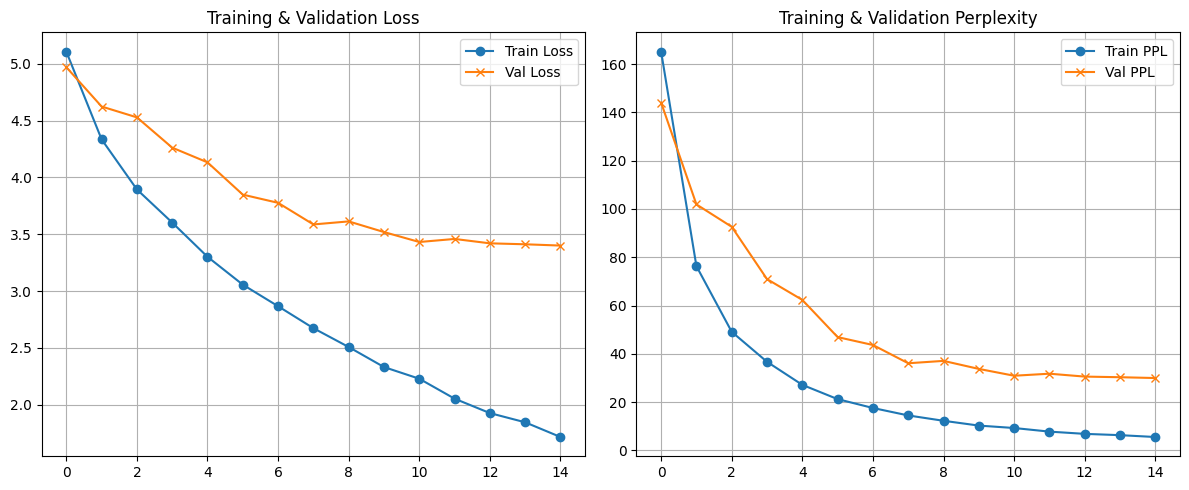

Đã lưu biểu đồ vào 'models/training_chart.png'


In [7]:
import matplotlib.pyplot as plt
# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='x')
plt.title('Training & Validation Loss')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_ppl'], label='Train PPL', marker='o')
plt.plot(history['val_ppl'], label='Val PPL', marker='x')
plt.title('Training & Validation Perplexity')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.savefig('models/training_chart.png')
plt.show()
print("Đã lưu biểu đồ vào 'models/training_chart.png'")

## 4. Dự đoán & Đánh giá (Inference & Evaluation)

Giai đoạn kiểm thử mô hình sau khi huấn luyện xong:

1.  **Dịch thử (Demo):** Chạy mô hình trên 5 câu tiếng Anh mẫu để kiểm tra ngữ nghĩa trực quan.
2.  **Tính điểm BLEU:**
    * Sử dụng thư viện `nltk.translate.bleu_score`.
    * Đánh giá độ chính xác của bản dịch máy so với bản dịch gốc trên toàn bộ tập **Test**.
    * **Yêu cầu:** BLEU Score > 15.0.

In [16]:
import torch
import random
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm # Dùng bản chuẩn đơn giản, ổn định
import os

# ==========================================
# 1. TẢI MÔ HÌNH
# ==========================================
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

# Load model tốt nhất
model_path = 'models/best_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Đã tải model: {model_path}")
else:
    print(f"Không tìm thấy model tại {model_path}")

model.eval()

# ==========================================
# 2. HÀM DỊCH
# ==========================================
def translate(sentence: str, max_len=50) -> str:
    model.eval()
    if isinstance(sentence, str): tokens = [t.lower() for t in tokenize_en(sentence)]
    else: tokens = [t.lower() for t in sentence]
    
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor, src_len)
    
    trg_indexes = [trg_vocab['<sos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_vocab['<eos>']: break
        
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return " ".join(trg_tokens[1:-1] if trg_tokens[-1] == '<eos>' else trg_tokens[1:])

# ==========================================
# 3. LẤY RANDOM TỪ TẬP TEST
# ==========================================
def show_random_examples(num_examples=5):
    print("\n" + "="*60)
    print(f"Ngẫu nhiên {num_examples} câu từ tập Test")
    print("="*60)
    
    with open_file_smart(TEST_EN) as f_en, open_file_smart(TEST_FR) as f_fr:
        en_lines = f_en.readlines()
        fr_lines = f_fr.readlines()
    
    indices = random.sample(range(len(en_lines)), num_examples)
    
    for idx in indices:
        src = clean_text(en_lines[idx])
        trg = clean_text(fr_lines[idx])
        pred = translate(src)
        
        print(f"Câu gốc (EN): {src}")
        print(f"Kết quả (FR): {trg}")
        print(f"Dự đoán (FR): {pred}")
        print("-" * 60)

# ==========================================
# 4. HÀM TÍNH BLEU (CÓ THANH PROGRESS BAR)
# ==========================================
def calculate_bleu(data_loader, model, device):
    model.eval()
    trgs = []
    pred_trgs = []
    
    # --- THANH CHẠY GIỐNG PHẦN TRAIN ---
    pbar = tqdm(data_loader, desc='Calculating BLEU', leave=False)
    
    with torch.no_grad():
        for src, trg, src_len in pbar:
            src = src.to(device)
            
            for i in range(src.shape[1]):
                # Lấy câu nguồn (bỏ padding)
                src_idxs = [x.item() for x in src[:, i] if x != src_vocab['<pad>']]
                src_tokens = [src_vocab.itos[x] for x in src_idxs][1:-1]
                
                # Dịch
                pred_tokens = translate(" ".join(src_tokens)).split()
                pred_trgs.append(pred_tokens)
                
                # Lấy câu đích (bỏ padding)
                trg_idxs = [x.item() for x in trg[:, i] if x != trg_vocab['<pad>']]
                trg_tokens = [trg_vocab.itos[x] for x in trg_idxs][1:-1]
                trgs.append([trg_tokens])

    return corpus_bleu(trgs, pred_trgs)

# ==========================================
# 5. CHẠY THỰC TẾ
# ==========================================
if __name__ == "__main__":
    # 1. Hiện 5 câu random
    show_random_examples(5)

    # 2. Tính BLEU
    print("\nTính toán BLEU Score toàn bộ tập Test...")
    if 'test_loader' in globals() and test_loader is not None:
        score = calculate_bleu(test_loader, model, device)
        print(f'\nBLEU Score = {score*100:.2f}')
    else:
        print("Không tìm thấy test_loader.")

Đã tải model: models/best_model.pth

Ngẫu nhiên 5 câu từ tập Test
Câu gốc (EN): a man next to a bicycle is playing a pan flute.
Kết quả (FR): un homme à côté d'un vélo joue de la flûte de pan.
Dự đoán (FR): un homme à côté d' un vélo fait une la de .
------------------------------------------------------------
Câu gốc (EN): a teenager plays her trumpet on the field at a game.
Kết quả (FR): une adolescente joue de la trompette sur le terrain pendant un match.
Dự đoán (FR): un adolescent joue de la sur le terrain lors d' un match .
------------------------------------------------------------
Câu gốc (EN): two young boys putting fruit on the bike.
Kết quả (FR): deux jeunes garçons mettant des fruits sur le vélo.
Dự đoán (FR): deux jeunes garçons partageant des marchandises sur le métro .
------------------------------------------------------------
Câu gốc (EN): a female police officer in a cap and navy uniform smiles while wearing sunglasses outside of a shop.
Kết quả (FR): une policière 


BLEU Score = 32.73
